In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Loading

In [110]:
df = pd.read_excel('premiums.xlsx')

In [112]:
df.shape

(50000, 13)

In [114]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


# Data Cleaning & EDA

In [115]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

### Making the column names consistent 

In [116]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [117]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

### Handling Null values

In [118]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [119]:
# Droping Null entries since the number of null entries are small

df.dropna(inplace=True)

In [120]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


we can identify outliers in age, number of dependents and income

### Handling Outliers

In [121]:
numerical_columns = df.select_dtypes(['int64', 'float64']).columns

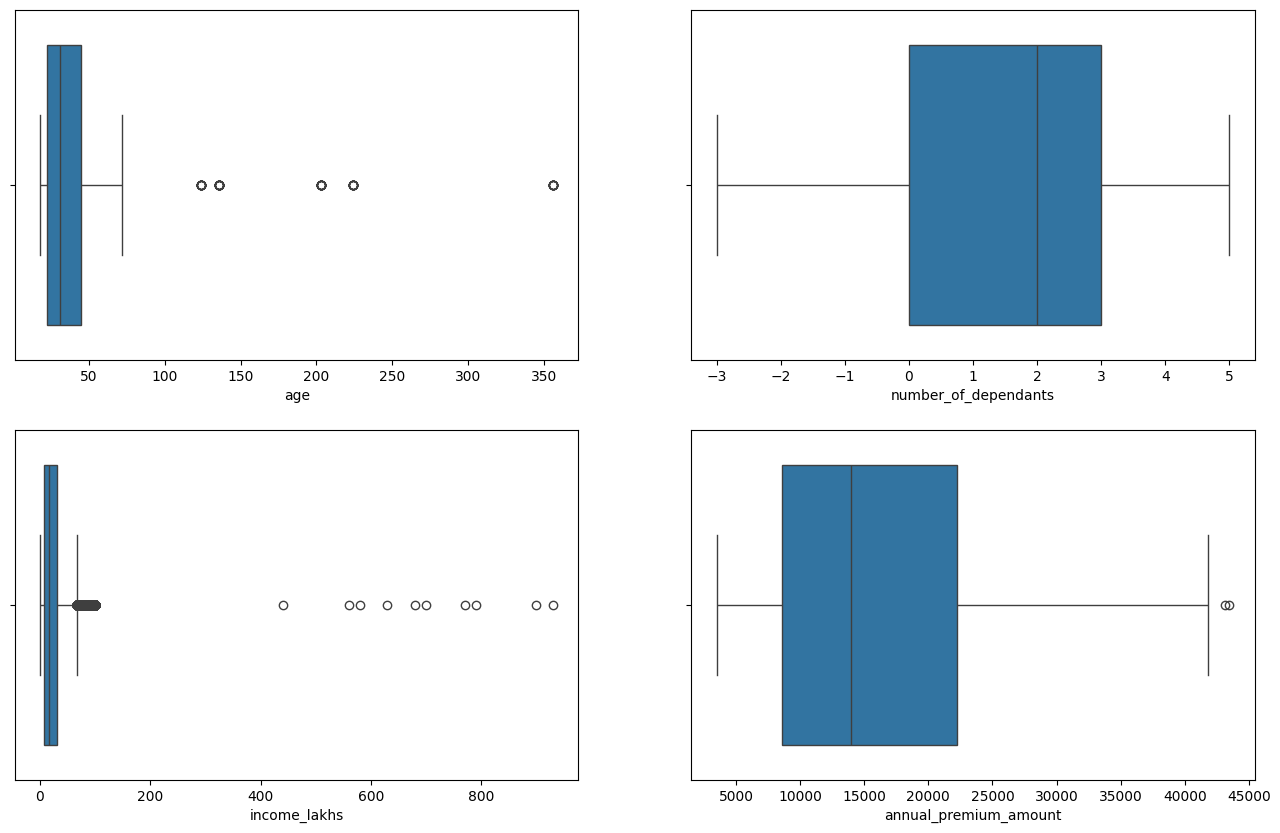

In [122]:
# Box plot to visualize outliers

plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(2,2,idx+1)
    sns.boxplot(data=df, x=col)
plt.show()  

In [123]:
# Number of dependents cannot be negative

df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [124]:
# Conisder max age to be 100 

df[df['age'] > 100].shape[0]

58

In [125]:
# Dropping entries with age > 100

df = df[df['age'] <= 100]
df.age.describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

In [126]:
def get_iqr_range(col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [127]:
lower, upper = get_iqr_range('income_lakhs')
lower, upper

# Here is ther upper bound for income is 67 lpa

(-29.0, 67.0)

In [128]:
income_upper_bound = df['income_lakhs'].quantile(0.999)

In [129]:
df[df['income_lakhs'] > income_upper_bound].shape[0]

10

In [130]:
# Conside 1 Cr as upper bound for income per year and Droping income outliers

df = df[df['income_lakhs'] <= income_upper_bound]

In [131]:
df.income_lakhs.describe()

count    49908.000000
mean        22.889897
std         22.170699
min          1.000000
25%          7.000000
50%         17.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64

### Distribution of Numerical columns

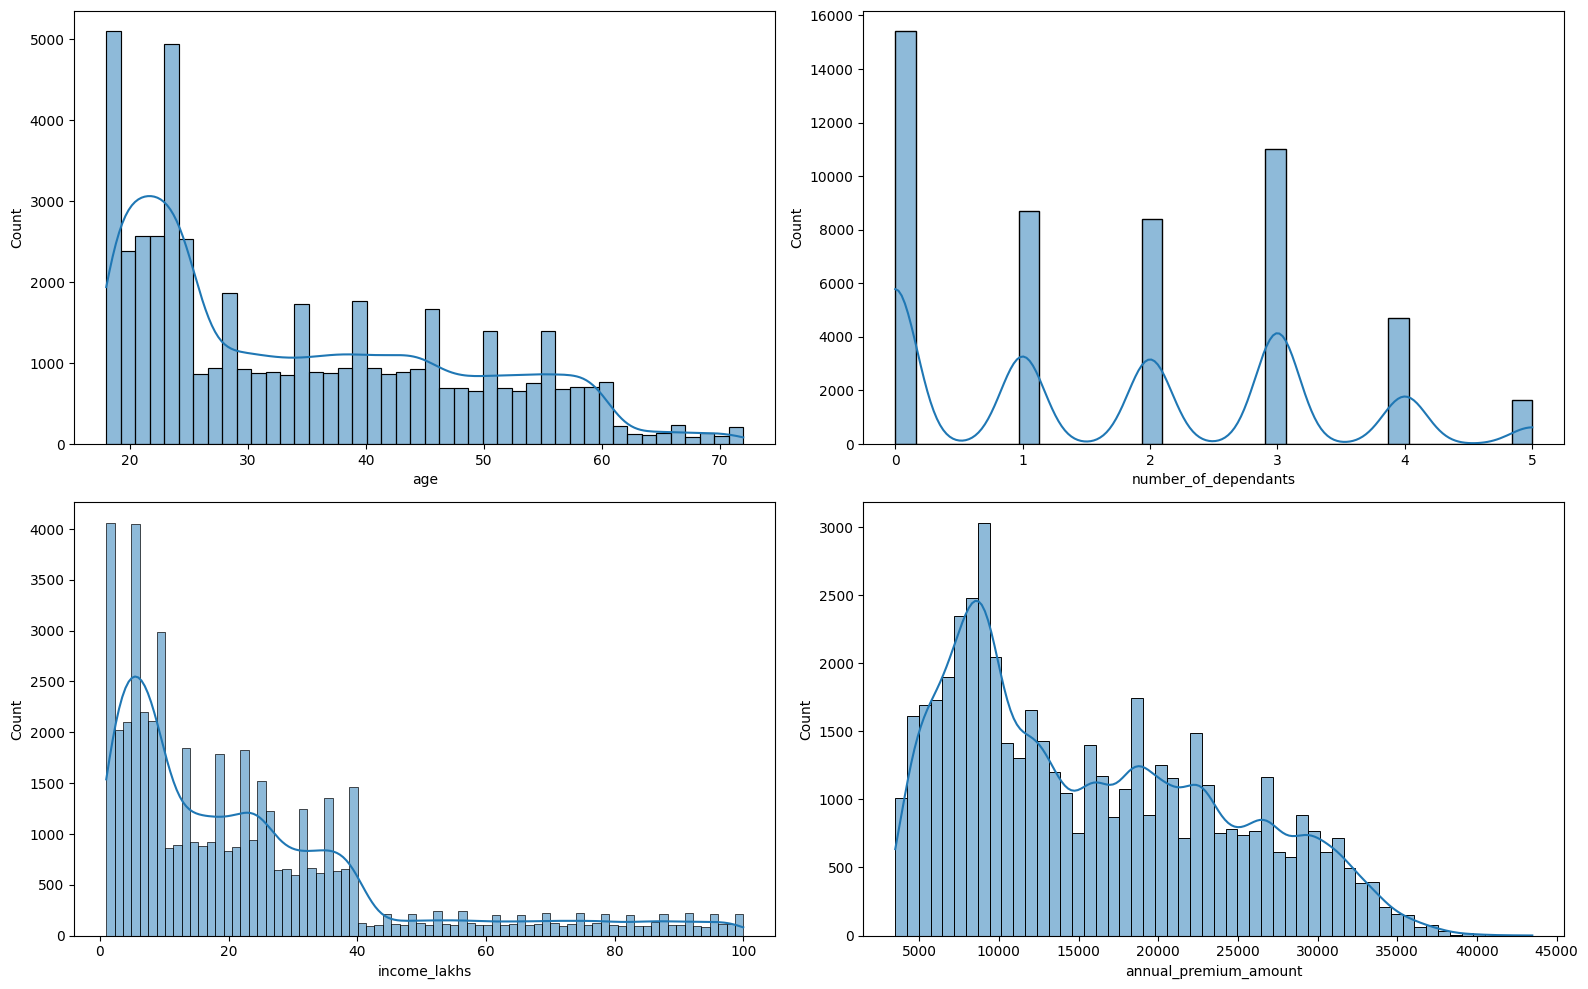

In [132]:
plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(2,2,idx+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show() 

From the distribution we can understand that the columns age, income, annual premium are right skewed

In [133]:
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [134]:
# Exploring the categorical values

for col in categorical_columns:
    print(f"{col} - {df[col].unique()}")

gender - ['Male' 'Female']
region - ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status - ['Unmarried' 'Married']
bmi_category - ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status - ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status - ['Salaried' 'Self-Employed' 'Freelancer']
income_level - ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history - ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan - ['Bronze' 'Silver' 'Gold']


In [135]:
# The smoking status is not uniform

df['smoking_status'] = df['smoking_status'].replace({
                        'Smoking=0': 'No Smoking',
                        'Does Not Smoke': 'No Smoking',
                        'Not Smoking': 'No Smoking'
                    })
df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Distribution of Categorical columns

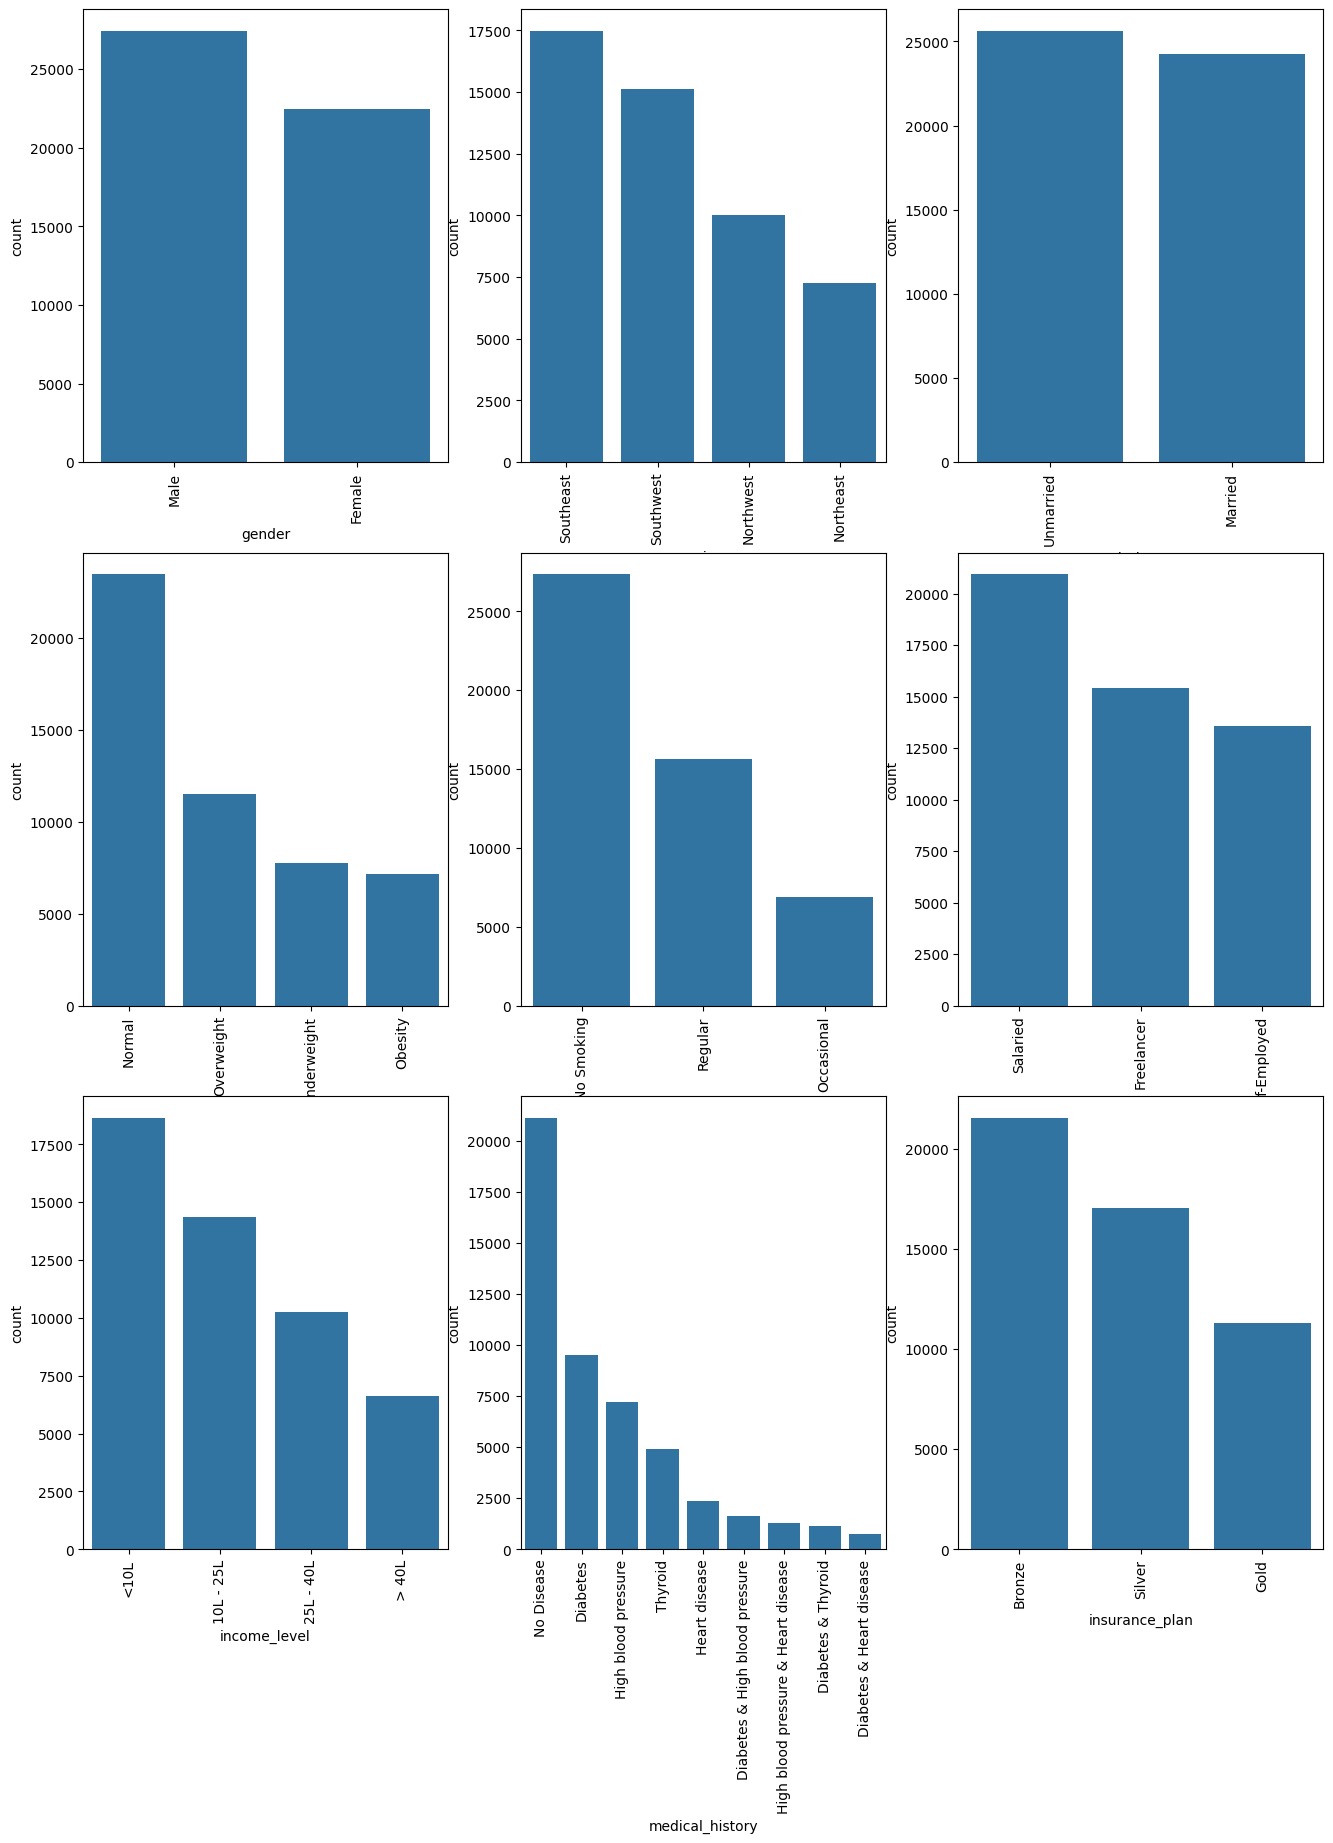

In [136]:
plt.figure(figsize=(16,20))
for idx, col in enumerate(categorical_columns):
    plt.subplot(3,3,idx+1)
    sns.barplot(df[col].value_counts())
    plt.xticks(rotation=90)
plt.show()

In [137]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


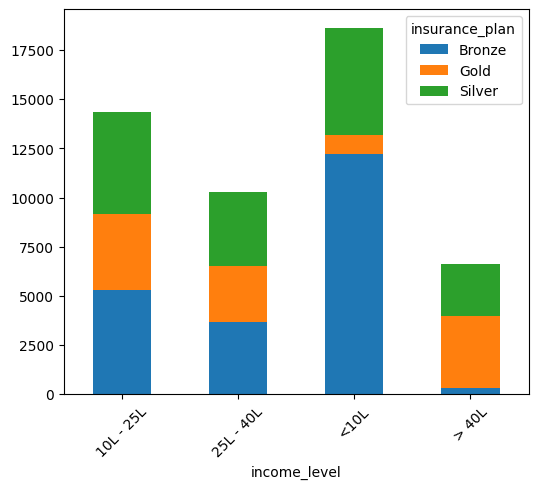

In [138]:
crosstab.plot(kind='bar', stacked=True, figsize=(6, 5))
plt.xticks(rotation=45)
plt.show()

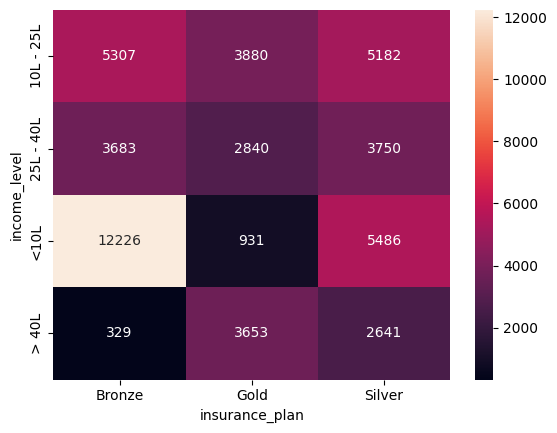

In [139]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

# Feature Engineering

In [140]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [141]:
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [142]:
df['medical_history'] = df['medical_history'].str.lower()

In [143]:
# Max a person has 2 disease so extracting into seprate columns

df[['disease1', 'disease2']] = df.medical_history.str.split(' & ', expand=True)

df['disease2'] = df['disease2'].fillna('none')

In [144]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df['total_risk_score'] = df['disease1'].map(risk_scores) + df['disease2'].map(risk_scores)

In [145]:
df['insurance_plan'] = df['insurance_plan'].map({"Bronze":1, "Silver":2, "Gold":3})

In [146]:
df['income_level'] = df['income_level'].map({"<10L":1, "10L - 25L":2, "25L - 40L":3, "> 40L":4})

In [147]:
cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0


In [148]:
# drop text columns

df.drop(columns=['medical_history', 'disease1', 'disease2'], inplace=True)

In [149]:
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,6,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,6,0,0,1,0,0,1,0,0,0,1,1,0


In [150]:
cols_to_norm = ['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'total_risk_score']
scaler = MinMaxScaler()
df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
df.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,1,0.050505,0.0,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,1,0.050505,0.0,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,2,0.191919,0.5,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,4,0.767677,1.0,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,4,0.989899,0.5,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


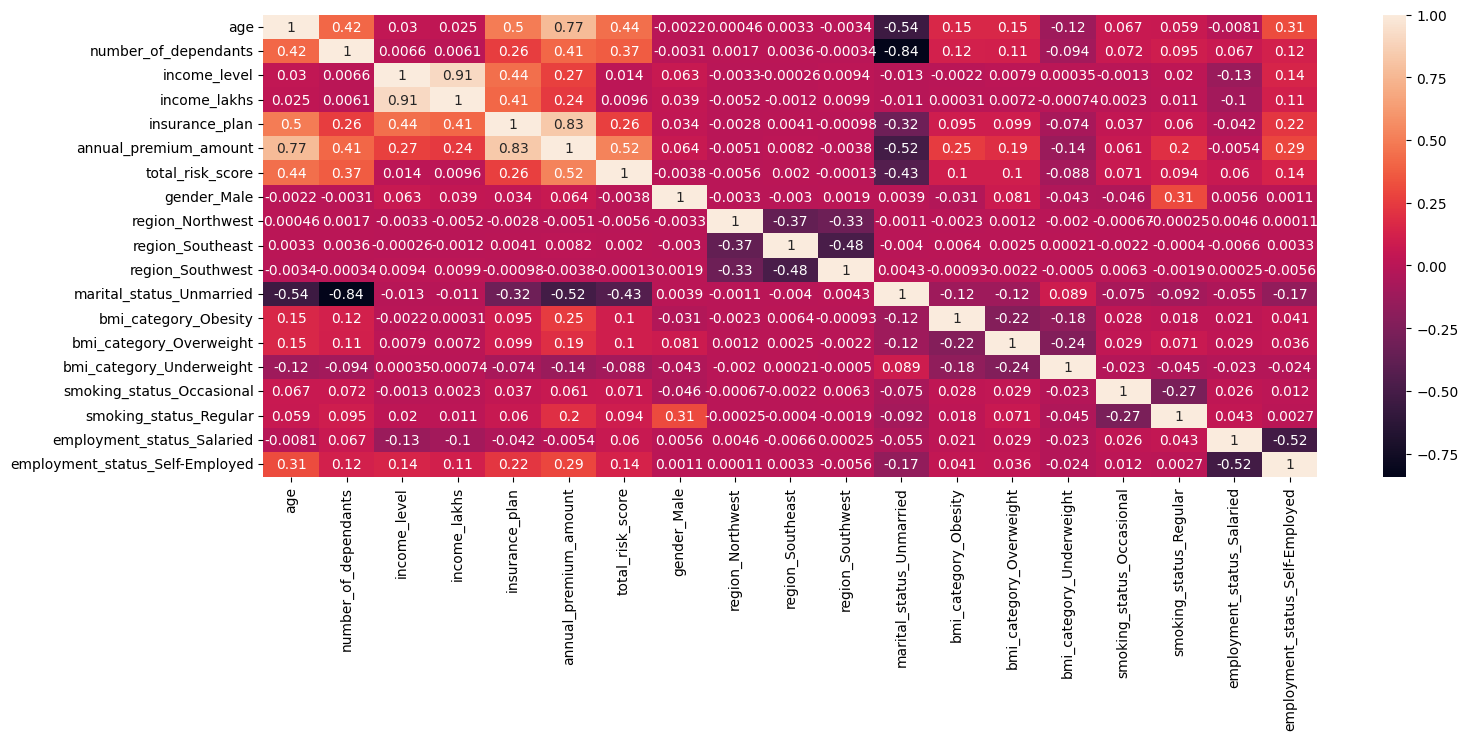

In [151]:
corr = df.corr()
plt.figure(figsize=(17,6))
sns.heatmap(corr, annot=True)
plt.show()

In [152]:
def get_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Features'] = data.columns
    vif_df['Values'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [153]:
get_vif(df.drop('annual_premium_amount', axis=1))

,Features,Values
0,age,4.554090
1,number_of_dependants,5.127355
2,income_level,24.639543
3,income_lakhs,10.157957
4,insurance_plan,3.560806
5,total_risk_score,2.698098
6,gender_Male,2.446651
7,region_Northwest,2.154506
8,region_Southeast,3.011129
9,region_Southwest,2.746476


In [154]:
get_vif(df.drop(['annual_premium_amount', 'income_level'], axis=1))

,Features,Values
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,total_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


removing column - income_level since it has a high VIF value.

In [155]:
df.drop('income_level', axis=1, inplace=True)

In [156]:
X = df.drop('annual_premium_amount', axis=1)
y = df['annual_premium_amount']

# Model Training

### Model Training - Linear Regression

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) 

model = LinearRegression()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

train_score, test_score

(0.9280119789452731, 0.9288253805309659)

In [158]:
model.intercept_

np.float64(4791.350831403201)

In [159]:
model.coef_

array([ 1.11677184e+04, -6.34882881e+02, -4.72445117e+02,  1.25303038e+04,
        4.82632905e+03,  1.59302998e+02, -2.58336677e+01,  4.86490726e+01,
       -1.13022701e+01, -9.02048154e+02,  3.38680650e+03,  1.61530519e+03,
        3.67779984e+02,  7.27024838e+02,  2.22620529e+03,  1.54259318e+02,
        4.05552308e+02])

In [160]:
X_train.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [161]:
feature_importance = pd.DataFrame(model.coef_, index=X_train.columns, columns=['value'])
feature_importance = feature_importance.sort_values(by='value', ascending=True)

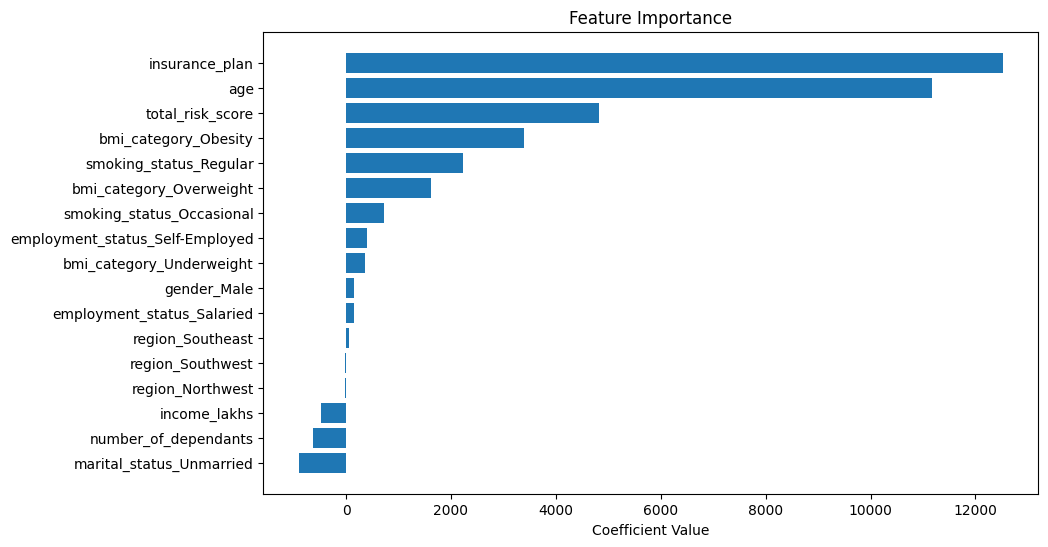

In [162]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance['value'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

In [163]:
y_pred = model.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.922650038884065
Mean Squared Error: 5156882.463210419
Mean Absolute Error: 1744.411885381665


### Model Training - SVM

In [164]:
from sklearn.svm import SVR

model_svr = SVR()
model_svr.fit(X_train, y_train)
train_score = model_svr.score(X_train, y_train)
test_score = model_svr.score(X_test, y_test)

train_score, test_score

(0.2267838614779909, 0.22541702979908718)

### Model Training - XGBoost

In [165]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

train_score, test_score

(0.9856743216514587, 0.9814035892486572)

In [166]:
y_pred = model_xgb.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.9810813069343567
Mean Squared Error: 1347384.25
Mean Absolute Error: 774.8145751953125


In [167]:
model_xgb = XGBRegressor()
params = {
    'n_estimators': [5, 10, 15],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.025, 0.5, 0.75]    
}

random_search = RandomizedSearchCV(model_xgb, params, n_iter=10, scoring='r2', cv=3)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.025, 0.5, 0.75],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [5, 10, 15]},
                   scoring='r2')

In [168]:
random_search.best_score_

np.float64(0.981123685836792)

In [169]:
random_search.best_params_

{'n_estimators': 5, 'max_depth': 7, 'learning_rate': 0.75}

In [170]:
best_model = random_search.best_estimator_

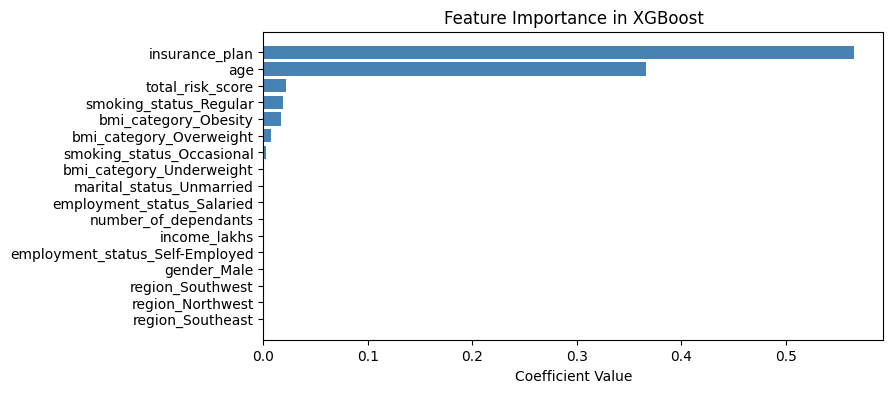

In [171]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

# Error Analysis

In [183]:
y_pred = best_model.predict(X_test)

diff = y_pred - y_test
diff_prc = diff*100/y_test

error_df = pd.DataFrame({
            "actual": y_test,
            "pred": y_pred,
            "difference": diff,
            "diff_prc": diff_prc
        })

In [184]:
error_df.head()

,actual,pred,difference,diff_prc
3598,20554,20542.324219,-11.675781,-0.056805
35794,29647,29759.619141,112.619141,0.379867
43608,20560,20297.556641,-262.443359,-1.276475
42730,5018,6538.186523,1520.186523,30.294670
18936,8929,8751.385742,-177.614258,-1.989184


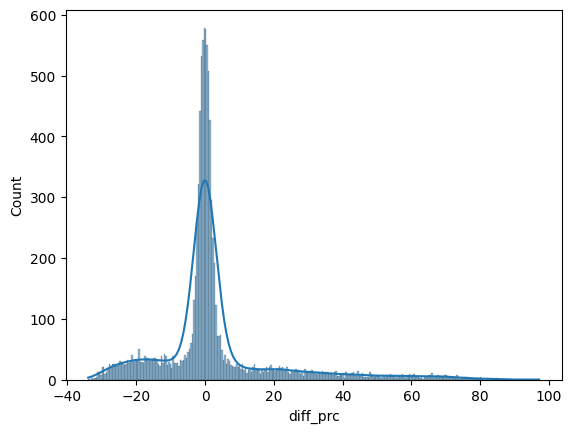

In [185]:
sns.histplot(error_df.diff_prc, kde=True)
plt.show()

In [188]:
extreme_error_df = error_df[np.abs(error_df.diff_prc) > 10] # difference >10%

In [190]:
extreme_error_pct = extreme_error_df.shape[0]*100/error_df.shape[0]
extreme_error_pct

29.563213784812664

In [195]:
extreme_error_df = X_test.loc[extreme_error_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


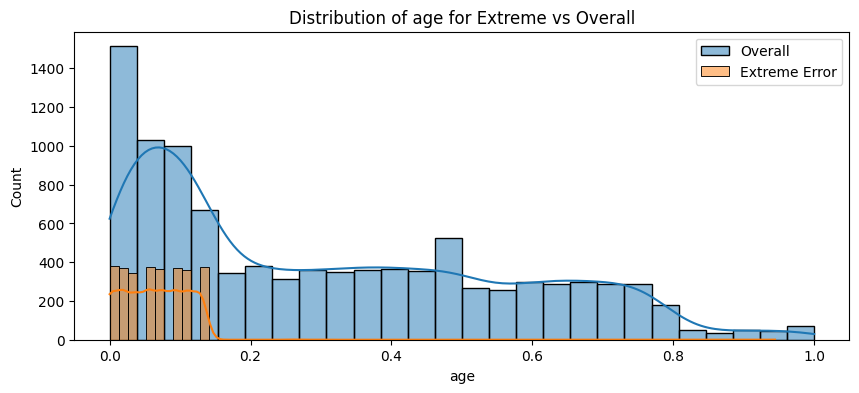

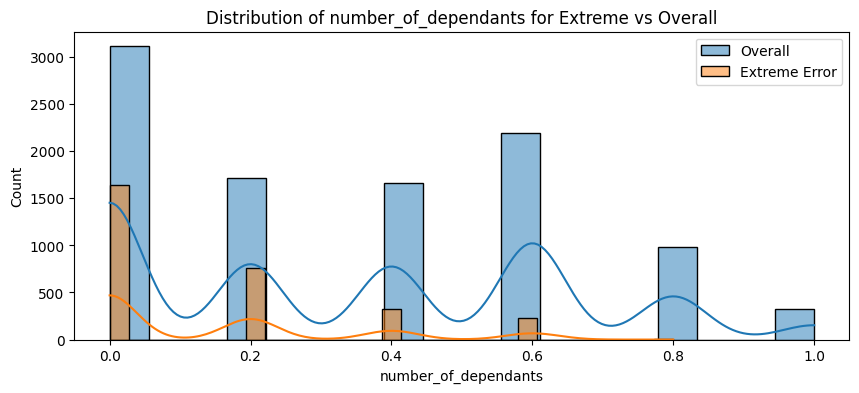

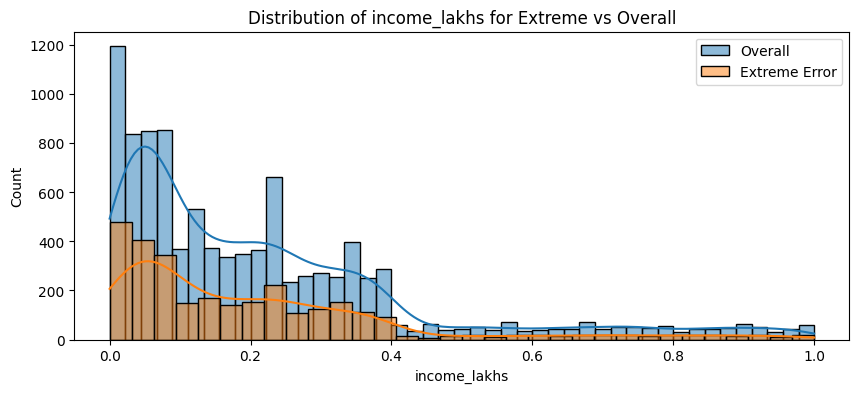

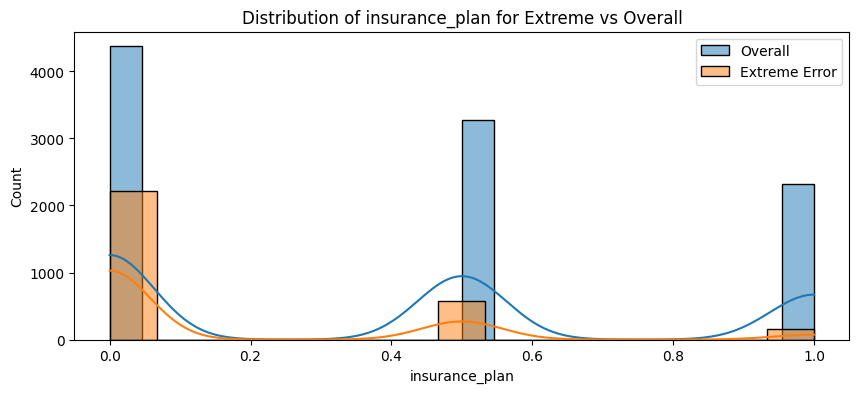

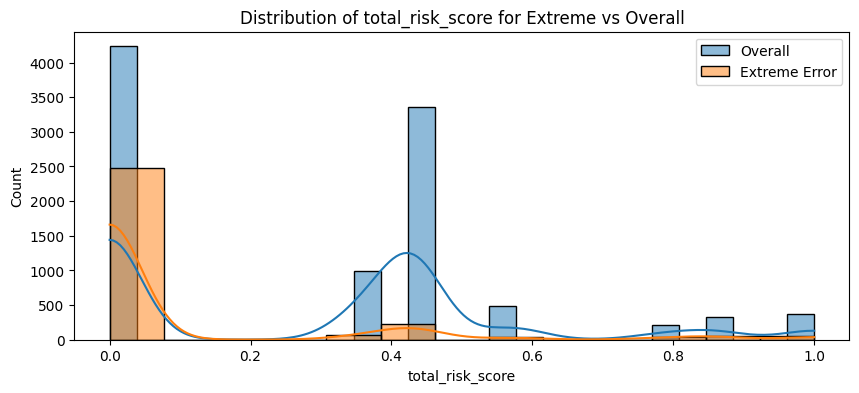

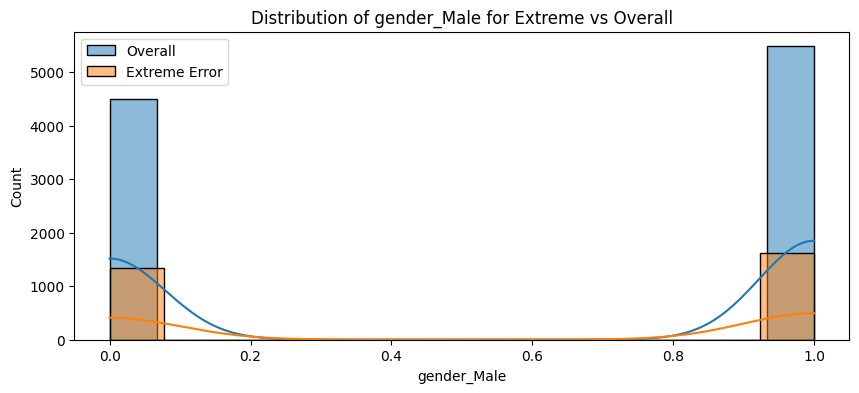

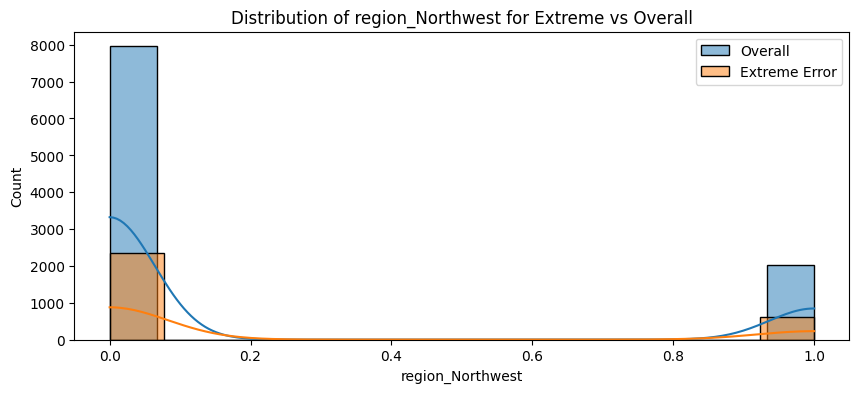

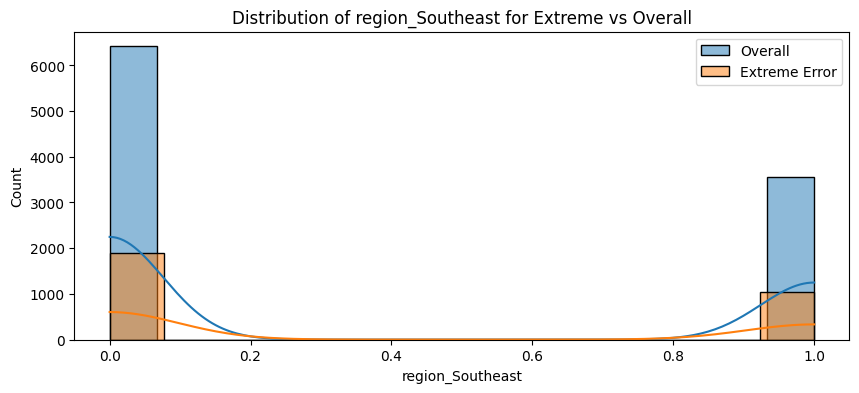

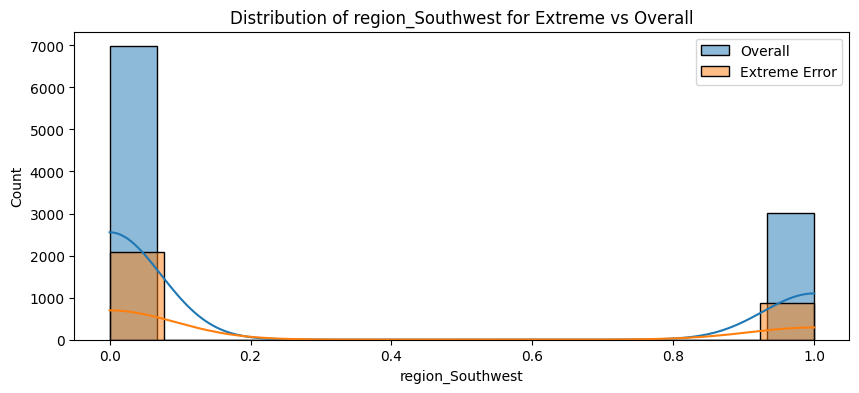

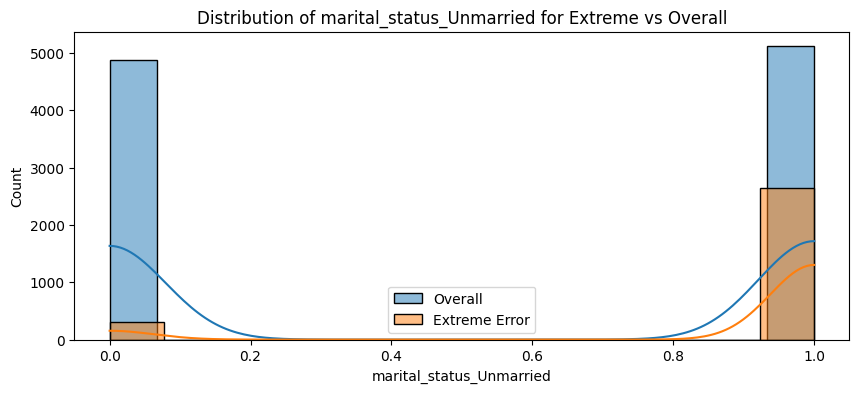

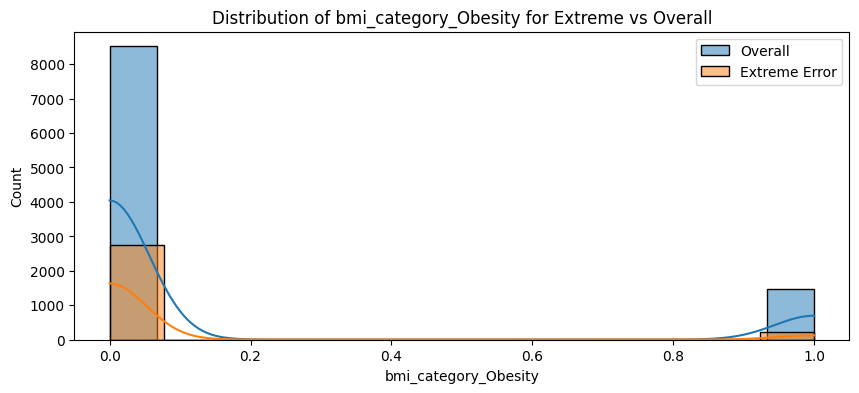

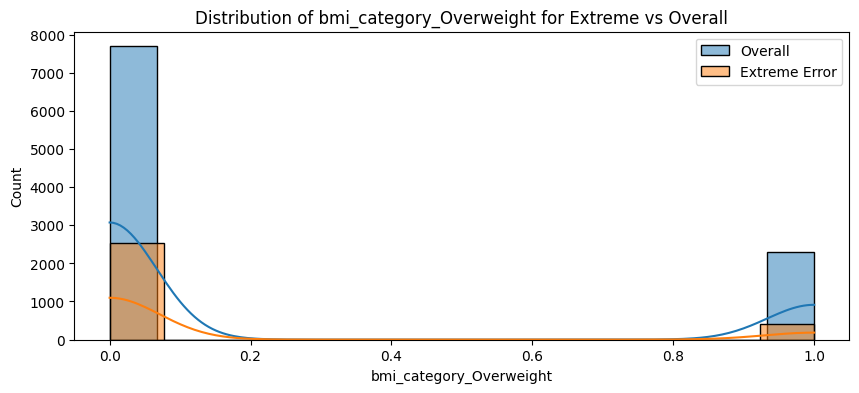

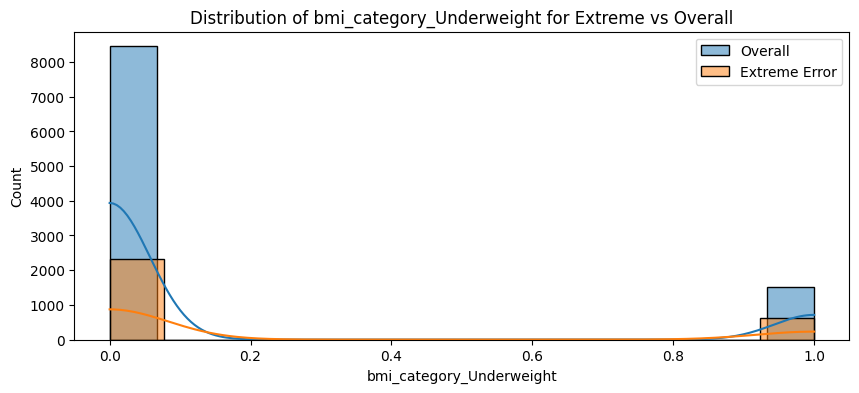

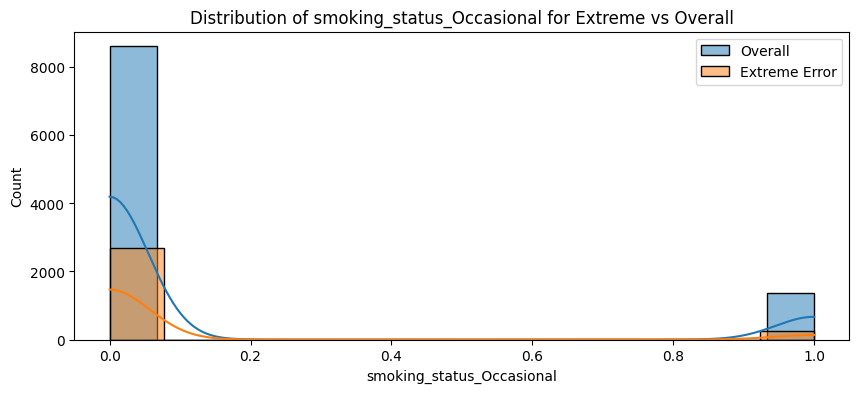

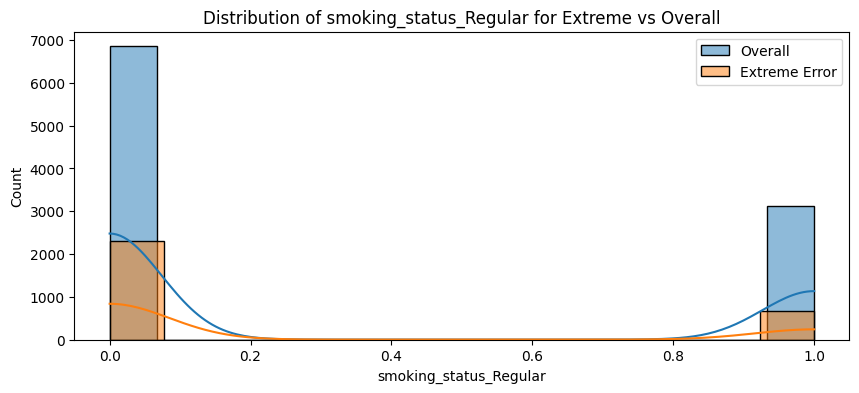

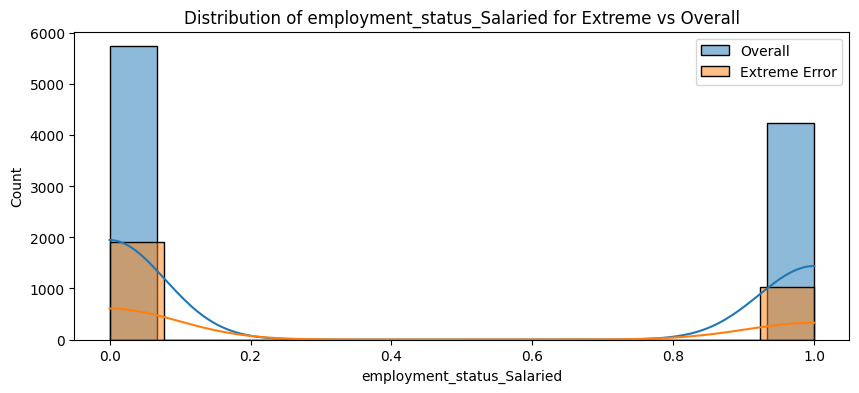

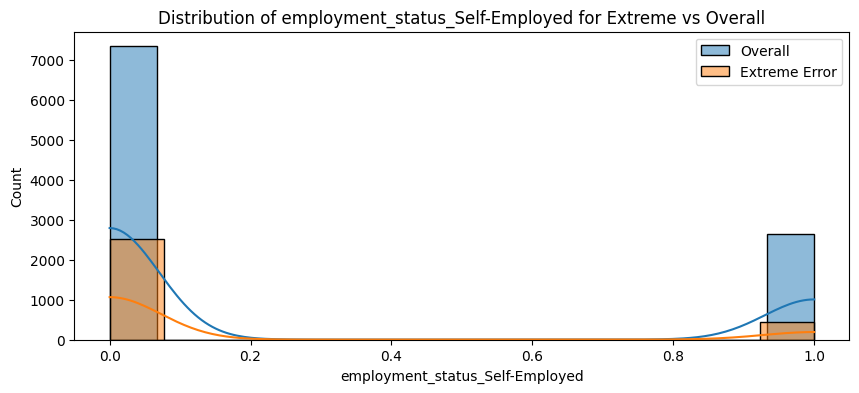

In [213]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], kde=True, label="Overall")
    sns.histplot(extreme_error_df[feature], kde=True, label="Extreme Errors")
    plt.title(f"Distribution of {feature} for Extreme vs Overall")
    plt.legend()
    plt.show()  # Ensure each plot is fully displayed


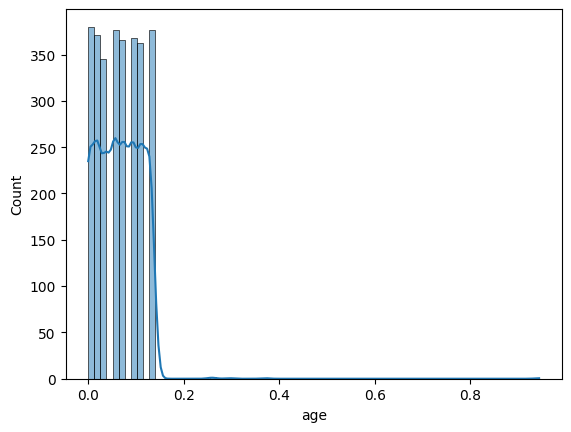

In [217]:
sns.histplot(extreme_error_df.age, kde=True)
plt.show()

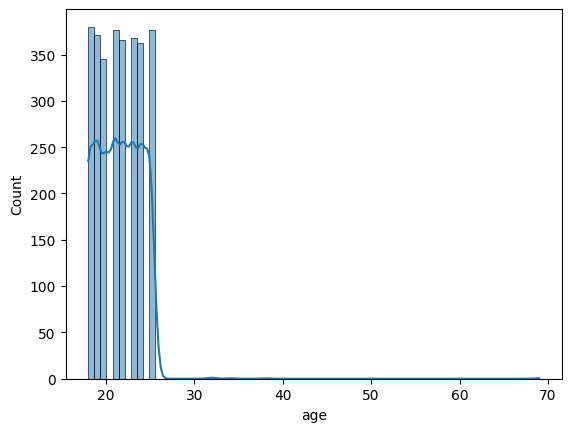

In [218]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_norm] = scaler.inverse_transform(extreme_error_df[cols_to_norm])

sns.histplot(df_reversed.age, kde=True)
plt.show()

Lower Age (< 25) group has high error. 